Run realTime

In [ ]:
from vision.pipelines.rgb_pipeline import get_repo_dir, run as run_rgb_pipeline, validate_output_path
import os
from omegaconf import OmegaConf

def run_real_time():
    repo_dir = get_repo_dir()
    pipeline_config = repo_dir + "vision/pipelines/config/pipeline_config.yaml"
    runtime_config = repo_dir + "/vision/pipelines/config/runtime_config.yaml"
    cfg = OmegaConf.load(pipeline_config)
    args = OmegaConf.load(runtime_config)
    movies_path = args.movie_path
    analysis_path = args.output_folder
    for scan in os.listdir(movies_path):
        for row in os.listdir(os.path.join(movies_path, scan)):
            args.movie_path = os.path.join(movies_path, scan, row, [i for i in os.listdir(os.path.join(movies_path, scan, row)) if i.endswith('.svo')][0])
            validate_output_path(os.path.join(analysis_path, scan))
            validate_output_path(os.path.join(analysis_path, scan, row))
            args.output_folder = os.path.join(analysis_path, scan, row)
            run_rgb_pipeline(cfg, args)

Diff PRE-POST

In [3]:
from scipy.stats import gaussian_kde

def diff_size(nonPicked_ratio, all_measures, nonPicked_measures):
    picked_ratio = 1 - nonPicked_ratio
    if picked_ratio == 0:
        return (0, 0), (0, 0), (0, 0)


    # By miu,sigma , assume normalization
    miu_all = all_measures.mean()
    sigma_all = all_measures.std()
    miu_nonPicked = nonPicked_measures.mean()
    sigma_nonPicked = nonPicked_measures.std()
    miu_picked = (1 / picked_ratio) * miu_all - (nonPicked_ratio / picked_ratio) * miu_nonPicked
    sigma_picked = np.sqrt((1 / picked_ratio) ** 2 * sigma_all ** 2 - (nonPicked_ratio / picked_ratio) ** 2 * sigma_nonPicked ** 2)

    # By kde
    # x_values = np.linspace(all_measures.min(), all_measures.max(), num=int(all_measures.max() - all_measures.min()))
    # kde_all = gaussian_kde(all_measures)(x_values)
    # kde_nonPicked = gaussian_kde(nonPicked_measures)(x_values)
    # kde_picked = (1 / picked_ratio) * kde_all - (nonPicked_ratio / picked_ratio) * kde_nonPicked
    # kde_miu = np.sum(kde_picked * x_values)
    # kde_sigma = np.sqrt(np.sum(kde_picked * (x_values - kde_miu) ** 2))

    # By hist
    hist_all, bins, p = plt.hist(all_measures,density=True)
    hist_nonPicked = plt.hist(nonPicked_measures, density=True,bins=bins)[0]
    hist_picked = (1 / picked_ratio) * hist_all - (nonPicked_ratio / picked_ratio) * hist_nonPicked
    hist_picked = hist_picked/ np.sum(hist_picked)
    bins = [(var+ bins[i + 1])/2 for i, var in enumerate(bins) if i+1 != len(bins)]
    hist_miu = np.sum(hist_picked * bins)
    hist_sigma = np.sqrt(np.sum(hist_picked * (bins - hist_miu) ** 2))

    plt.close()
    return (miu_picked, sigma_picked), (None, None), (hist_miu, hist_sigma)

In [4]:
def map_tree_into_plot(row,T,type = 'tomato'):
    df = pd.read_csv(r'C:\Users\frodo\OneDrive - FruitSpec\Syngenta\Mapping\Map_trees_to_plot.csv')
    t = df[(df['row']==int(row)) & (df['tree_id']==T) & (df['type']==type)]
    try:
        res = t.iloc[0]['plot']
    except:
        print('ERROR in plot mapping, row: ' , row, 'tree_num:', T)
        return 0000
    return res

Check slicing

In [5]:
plot_num_dict = {'7': 12,'8':12,'9':13,'10':15,'11':15,'18':8,'19':8,'20':8,'21':8}

In [6]:
from vision.tools.manual_slicer import slice_to_trees
import os
path = r'C:\Users\frodo\OneDrive - FruitSpec\Syngenta\tomato\230123'
for scan in os.listdir(path):
    if os.path.isfile(os.path.join(path,scan)):
        continue
    for row in os.listdir(os.path.join(path,scan)):
        try:
            json_path = os.path.join(path,scan,row, [i for i in os.listdir(os.path.join(path,scan,row)) if 'slice_data' in i][0])
        except Exception as e:
            continue
        exist_plots = len(slice_to_trees(json_path,None,None)['tree_id'].unique())
        GT_plots = plot_num_dict[row]
        if GT_plots == exist_plots:
            print(f'{scan} - {row} - completed!')
        else:
            print(f'{scan} - {row} - {exist_plots}/{GT_plots}')

post - 10 - completed!
post - 11 - completed!
post - 18 - completed!
post - 20 - completed!
post - 21 - completed!
post - 7 - completed!
post - 8 - completed!
post - 9 - completed!
pre - 10 - completed!
pre - 11 - completed!
pre - 18 - completed!
pre - 20 - completed!
pre - 21 - completed!
pre - 7 - completed!
pre - 8 - completed!
pre - 9 - completed!


Run Counter

In [7]:
import os
from vision.tools.manual_slicer import slice_to_trees
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
def open_measures(path):
    df = pd.read_csv(os.path.join(path, 'measures.csv'))
    return df

In [9]:
def bound_red_fruit(df):
    # filter out clusters that have only green fruits
    df_red = df[(df['color']<60) & (df['color']>0)]
    if df_red.empty:
        return pd.DataFrame(columns=df.columns)
    min_red = df_red['y1'].min()
    df = df[df['y1']>min_red]
    return df

In [10]:
def trackers_into_value(df_tree, df_res, analysis='counter'):

    def color(x):
        if x>0 and x<25:
            return 1
        elif x>25 and x<45:
            return 2
        elif x>45 and x<65:
            return 3
        elif x>90 and x<165:
            return 4

    if df_tree is not None:
        df_tree['end'].replace([-1], math.inf,inplace=True)
    plot_det = []
    const = 10
    for frame_id, df_frame in df_res.groupby('frame'):
        df_frame = bound_red_fruit(df_frame)
        if df_tree is not None:
            limit = df_tree[df_tree['frame_id'] == frame_id]
            if limit.empty or df_frame.empty:
                continue
            limit = limit.iloc[0]
            df = df_frame[(df_frame['x2'] + const > limit['start']) & (df_frame['x1'] < limit['end'] - const)]
        else:
            df =df_frame
        plot_det.append(df)

    df_res = pd.concat(plot_det,axis=0)

    if analysis == 'color':
        counter = len(df_res['track_id'].unique())
        df_res = df_res[(df_res['color'] < 65) | ((df_res['color'] > 90) & (df_res['color'] < 165))]
        df_group = df_res.groupby('track_id')
        colors_class = df_group.apply(lambda x : color(x.color.mean())).dropna().astype(int)
        return counter, colors_class
    elif analysis == 'size':
        counter = len(df_res['track_id'].unique())
        df_res = df_res[(df_res['height'] < 90) & (df_res['width'] < 90)]
        df_group = df_res.groupby('track_id')
        measures = df_group.apply(lambda x : x.width.max() if x.width.mean() > x.height.mean() else x.height.max())
        return counter,measures
    elif analysis == 'counter':
        counter = len(df_res['track_id'].unique())
        return counter, None

    return None,None

In [9]:
def apply_trees_counter(path, row, single=False):
    df = pd.DataFrame()
    # in case that no measures.csv or no json
    try:
        row_folder = os.path.join(path, row)
        df_res = open_measures(row_folder)
        trees_slices = slice_to_trees(os.path.join(row_folder, [i for i in os.listdir(row_folder) if 'slice_data' in i][0]), None, None)
    except Exception as e:
        if single and 'df_res' in locals():
            count, _ = trackers_into_value(None, df_res, 'counter')
            plot_id = map_tree_into_plot(row, 1)
            df = df.append({'row': row, 'plot_id': plot_id, 'fruits_num': count}, ignore_index=True)
            return df
        print(repr(e), path, row)
        return df
    for tree_id, df_tree in trees_slices.groupby('tree_id'):
        count, _ = trackers_into_value(df_tree, df_res, analysis='counter')
        plot_id = map_tree_into_plot(row, tree_id)
        df = df.append({'row': row, 'plot_id': plot_id, 'fruits_num': count}, ignore_index=True)
    return df

In [33]:
def run_counter(scan_pre, scan_post):
    df_pre,df_post = pd.DataFrame(),pd.DataFrame()
    for (pre,post) in zip(os.listdir(scan_pre),os.listdir(scan_post)):
        single = False
        if post in ['1','2','3','4','5','6','12','13','14','15','16','17']:
            single = True
        else:
            continue
        df_pre = pd.concat([df_pre,apply_trees_counter(scan_pre,pre,single)],axis=0)
        df_post = pd.concat([df_post,apply_trees_counter(scan_post,post,single)],axis=0)
    df_sum = df_pre.merge(df_post,how='inner',on = ['row','plot_id'],suffixes=['_pre','_post'])
    df_sum['diff'] = np.maximum(df_sum['fruits_num_pre'] - df_sum['fruits_num_post'],0)
    return df_pre, df_post ,df_sum

In [35]:
scan_pre = fr'C:\Users\frodo\OneDrive - FruitSpec\Syngenta\tomato\230123\pre'
scan_post = fr'C:\Users\frodo\OneDrive - FruitSpec\Syngenta\tomato\230123\post'
output_path = fr'C:\Users\frodo\OneDrive - FruitSpec\Syngenta\tomato\230123\results_060223.csv'

gt = pd.read_csv(fr'C:\Users\frodo\OneDrive - FruitSpec\Syngenta\tomato\230123\ground_truth.csv')
gt = gt[['plot_id','GT-C']]
df_pre, df_post, df = run_counter(scan_pre,scan_post)
df = df.merge(gt,how='left',on = ['plot_id'])
df['error_count'] = df['diff']-df['GT-C']
df['error'] = abs(df['error_count']/df['GT-C'])
df['acc'] = 1 - df['error']
df.to_csv(output_path,index=False)

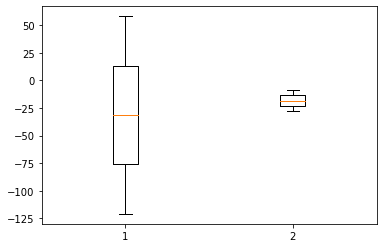

-31.5 -18.5


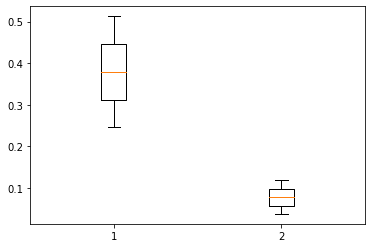

0.3792372881355932 0.0783898305084745


In [29]:
df = pd.read_csv(output_path,dtype={'row':str})
df_1 = df[df["row"].isin(['9','11','7','13','15','5','3','17','1','19','21','25'])]
df_2 = df[df["row"].isin(['10','8','12','12','6','14','4','16','2','18','20','26'])]

df_1.to_csv(r"C:\Users\frodo\OneDrive - FruitSpec\Syngenta\tomato\230123\side_1_count.csv")
df_2.to_csv(r"C:\Users\frodo\OneDrive - FruitSpec\Syngenta\tomato\230123\side_2_count.csv")

plt.boxplot([df_1['error_count'].dropna(),df_2['error_count'].dropna()],vert=1)
plt.show()
print(df_1['error_count'].mean(),df_2['error_count'].mean())

plt.boxplot([df_1['error'].dropna(),df_2['error'].dropna()],vert=1)
plt.show()
print(df_1['error'].mean(),df_2['error'].mean())

Run Size

In [36]:
def apply_trees_size(path,row):
    row_folder = os.path.join(path,row)
    df_res = open_measures(row_folder)
    trees_slices = slice_to_trees(os.path.join(row_folder, [i for i in os.listdir(row_folder) if 'slice_data' in i][0]),None,None)
    for tree_id, df_tree in trees_slices.groupby('tree_id'):
        count, measures = trackers_into_value(df_tree,df_res,analysis='size')
        plot_id = map_tree_into_plot(row, tree_id)
        yield plot_id, count, measures

In [37]:
def run_size_plots(scan_pre, scan_post):
    df_sum = pd.DataFrame()
    for (pre, post) in zip(os.listdir(scan_pre), os.listdir(scan_post)):
        if post in ['1', '2', '3', '4', '5', '6', '12', '13', '14', '15', '16', '17']:
            continue
        for (pre_plot_id, pre_count, pre_measures), (post_plot_id, post_count, post_measures) in zip(apply_trees_size(scan_pre, pre), apply_trees_size(scan_post, post)):
            (miu_picked, sigma_picked), (kde_miu, kde_sigma), (hist_miu, hist_sigma) = diff_size(post_count / pre_count, pre_measures, post_measures)
            weight_miu = 11.475 * np.exp(0.0359 * miu_picked)
            weight_sigma = 11.475 * np.exp(0.0359 * sigma_picked)

            df_sum = df_sum.append({'row': pre,
                                    'plot_id': pre_plot_id,
                                    "avg_size": miu_picked,
                                    "std_size": sigma_picked,
                                    "avg_weight": weight_miu,
                                    "std_weight": weight_sigma}, ignore_index=True)
    return df_sum

In [41]:
def run_size_com(scan_pre, scan_post):
    df_sum = pd.DataFrame()
    for (row1, row2) in [('3', '15'), ('5', '13'), ('6', '12'), ('1', '17'), ('2', '16')]:
        pre_measures = pd.Series()
        pre_count = 0
        post_measures = pd.Series()
        post_count = 0
        for row in (row1, row2):
            row_folder = os.path.join(scan_pre, row)
            df_res = open_measures(row_folder)
            count, measures = trackers_into_value(None, df_res, analysis='size')
            pre_measures = pd.concat([pre_measures, measures], axis=0)
            pre_count += count

            row_folder = os.path.join(scan_post, row)
            df_res = open_measures(row_folder)
            count, measures = trackers_into_value(None, df_res, analysis='size')
            post_measures = pd.concat([post_measures, measures], axis=0)
            post_count += count

        (miu_picked, sigma_picked), (kde_miu, kde_sigma), (hist_miu, hist_sigma) = diff_size(post_count/pre_count, pre_measures, post_measures)
        weight_miu = 11.475*np.exp(0.0359* miu_picked)
        weight_sigma = 11.475*np.exp(0.0359* sigma_picked)

        df_sum = df_sum.append({'row': (row1,row2),
                                'plot_id': None,
                                "avg_size":miu_picked,
                                "std_size":sigma_picked,
                                "avg_weight":weight_miu,
                                "std_weight":weight_sigma}, ignore_index=True)
    return df_sum

In [42]:
scan_pre = fr'C:\Users\frodo\OneDrive - FruitSpec\Syngenta\tomato\230123\pre'
scan_post = fr'C:\Users\frodo\OneDrive - FruitSpec\Syngenta\tomato\230123\post'
output_path = fr'C:\Users\frodo\OneDrive - FruitSpec\Syngenta\tomato\230123\results_size.csv'
df_SIZE = run_size_plots(scan_pre,scan_post)
df_SIZE.to_csv(output_path,index=False,mode="w")
df_SIZE = run_size_com(scan_pre,scan_post)
df_SIZE.to_csv(output_path,index=False,mode="a+")

10 0.08 10 125
10 0.4691358024691358 38 81
10 0.45054945054945056 41 91
10 0.38095238095238093 32 84
10 0.9558823529411765 65 68


C:\Users\frodo\AppData\Local\Temp\ipykernel_10996\415682211.py:15: RuntimeWarning: invalid value encountered in sqrt
  sigma_picked = np.sqrt((1 / picked_ratio) ** 2 * sigma_all ** 2 - (nonPicked_ratio / picked_ratio) ** 2 * sigma_nonPicked ** 2)
C:\Users\frodo\AppData\Local\Temp\ipykernel_10996\415682211.py:32: RuntimeWarning: invalid value encountered in sqrt
  hist_sigma = np.sqrt(np.sum(hist_picked * (bins - hist_miu) ** 2))


10 0.7073170731707317 58 82


C:\Users\frodo\AppData\Local\Temp\ipykernel_10996\415682211.py:32: RuntimeWarning: invalid value encountered in sqrt
  hist_sigma = np.sqrt(np.sum(hist_picked * (bins - hist_miu) ** 2))


10 0.734375 47 64
10 0.352112676056338 25 71
10 0.527027027027027 39 74
10 0.647887323943662 46 71
10 0.7738095238095238 65 84
10 0.8142857142857143 57 70
10 0.8108108108108109 30 37
10 0.9210526315789473 70 76
10 0.9555555555555556 43 45


C:\Users\frodo\AppData\Local\Temp\ipykernel_10996\415682211.py:15: RuntimeWarning: invalid value encountered in sqrt
  sigma_picked = np.sqrt((1 / picked_ratio) ** 2 * sigma_all ** 2 - (nonPicked_ratio / picked_ratio) ** 2 * sigma_nonPicked ** 2)
C:\Users\frodo\AppData\Local\Temp\ipykernel_10996\415682211.py:32: RuntimeWarning: invalid value encountered in sqrt
  hist_sigma = np.sqrt(np.sum(hist_picked * (bins - hist_miu) ** 2))


11 0.3230769230769231 21 65
11 0.5203252032520326 64 123
11 1.2258064516129032 38 31


C:\Users\frodo\AppData\Local\Temp\ipykernel_10996\415682211.py:32: RuntimeWarning: invalid value encountered in sqrt
  hist_sigma = np.sqrt(np.sum(hist_picked * (bins - hist_miu) ** 2))


11 0.9466666666666667 71 75
11 0.5345911949685535 85 159
11 0.872093023255814 75 86


C:\Users\frodo\AppData\Local\Temp\ipykernel_10996\415682211.py:32: RuntimeWarning: invalid value encountered in sqrt
  hist_sigma = np.sqrt(np.sum(hist_picked * (bins - hist_miu) ** 2))


11 0.5490196078431373 56 102
11 0.5918367346938775 58 98
11 0.575 69 120
11 0.6612903225806451 82 124
11 0.5307692307692308 69 130
11 0.5444444444444444 49 90
11 0.559322033898305 66 118
11 0.5087719298245614 58 114
11 0.42727272727272725 47 110
18 0.7530864197530864 61 81
18 1.0 41 41
18 0.6212121212121212 41 66
18 0.7205882352941176 49 68
18 0.7777777777777778 56 72
18 1.4285714285714286 60 42


C:\Users\frodo\AppData\Local\Temp\ipykernel_10996\415682211.py:15: RuntimeWarning: invalid value encountered in sqrt
  sigma_picked = np.sqrt((1 / picked_ratio) ** 2 * sigma_all ** 2 - (nonPicked_ratio / picked_ratio) ** 2 * sigma_nonPicked ** 2)


18 0.6444444444444445 29 45
18 0.8536585365853658 70 82


C:\Users\frodo\AppData\Local\Temp\ipykernel_10996\415682211.py:32: RuntimeWarning: invalid value encountered in sqrt
  hist_sigma = np.sqrt(np.sum(hist_picked * (bins - hist_miu) ** 2))


20 0.6076923076923076 79 130
20 0.46551724137931033 27 58
20 0.5 53 106
20 0.5060240963855421 42 83
20 0.9622641509433962 51 53


C:\Users\frodo\AppData\Local\Temp\ipykernel_10996\415682211.py:15: RuntimeWarning: invalid value encountered in sqrt
  sigma_picked = np.sqrt((1 / picked_ratio) ** 2 * sigma_all ** 2 - (nonPicked_ratio / picked_ratio) ** 2 * sigma_nonPicked ** 2)
C:\Users\frodo\AppData\Local\Temp\ipykernel_10996\415682211.py:32: RuntimeWarning: invalid value encountered in sqrt
  hist_sigma = np.sqrt(np.sum(hist_picked * (bins - hist_miu) ** 2))


20 0.5714285714285714 32 56
20 0.7403846153846154 77 104
20 0.7608695652173914 35 46
21 0.8875 71 80
21 0.8351648351648352 76 91
21 0.6266666666666667 47 75
21 0.7391304347826086 51 69
21 0.611764705882353 52 85
21 0.7671232876712328 56 73
21 0.390625 25 64
21 0.5714285714285714 52 91
7 0.8378378378378378 62 74
7 0.7752808988764045 69 89
7 0.703125 45 64
7 0.9166666666666666 55 60


C:\Users\frodo\AppData\Local\Temp\ipykernel_10996\415682211.py:32: RuntimeWarning: invalid value encountered in sqrt
  hist_sigma = np.sqrt(np.sum(hist_picked * (bins - hist_miu) ** 2))


7 1.2134831460674158 108 89


C:\Users\frodo\AppData\Local\Temp\ipykernel_10996\415682211.py:15: RuntimeWarning: invalid value encountered in sqrt
  sigma_picked = np.sqrt((1 / picked_ratio) ** 2 * sigma_all ** 2 - (nonPicked_ratio / picked_ratio) ** 2 * sigma_nonPicked ** 2)


7 1.0520833333333333 101 96


C:\Users\frodo\AppData\Local\Temp\ipykernel_10996\415682211.py:32: RuntimeWarning: invalid value encountered in sqrt
  hist_sigma = np.sqrt(np.sum(hist_picked * (bins - hist_miu) ** 2))


7 0.6037735849056604 32 53
7 0.95 76 80
7 0.8653846153846154 45 52


C:\Users\frodo\AppData\Local\Temp\ipykernel_10996\415682211.py:15: RuntimeWarning: invalid value encountered in sqrt
  sigma_picked = np.sqrt((1 / picked_ratio) ** 2 * sigma_all ** 2 - (nonPicked_ratio / picked_ratio) ** 2 * sigma_nonPicked ** 2)
C:\Users\frodo\AppData\Local\Temp\ipykernel_10996\415682211.py:32: RuntimeWarning: invalid value encountered in sqrt
  hist_sigma = np.sqrt(np.sum(hist_picked * (bins - hist_miu) ** 2))


7 0.5739130434782609 66 115
7 0.8041237113402062 78 97
7 0.539568345323741 75 139
8 0.22707423580786026 52 229
8 0.7191011235955056 64 89
8 0.7272727272727273 64 88
8 0.6730769230769231 35 52
8 0.6 39 65
8 0.7307692307692307 38 52
8 0.6233766233766234 48 77
8 0.6938775510204082 34 49
8 0.8974358974358975 35 39


C:\Users\frodo\AppData\Local\Temp\ipykernel_10996\415682211.py:15: RuntimeWarning: invalid value encountered in sqrt
  sigma_picked = np.sqrt((1 / picked_ratio) ** 2 * sigma_all ** 2 - (nonPicked_ratio / picked_ratio) ** 2 * sigma_nonPicked ** 2)


8 0.3870967741935484 24 62
8 0.45121951219512196 37 82
8 0.7301587301587301 46 63
9 0.3709677419354839 46 124
9 0.8936170212765957 84 94


C:\Users\frodo\AppData\Local\Temp\ipykernel_10996\415682211.py:32: RuntimeWarning: invalid value encountered in sqrt
  hist_sigma = np.sqrt(np.sum(hist_picked * (bins - hist_miu) ** 2))


9 0.7567567567567568 112 148


C:\Users\frodo\AppData\Local\Temp\ipykernel_10996\415682211.py:32: RuntimeWarning: invalid value encountered in sqrt
  hist_sigma = np.sqrt(np.sum(hist_picked * (bins - hist_miu) ** 2))


9 1.021505376344086 95 93


C:\Users\frodo\AppData\Local\Temp\ipykernel_10996\415682211.py:32: RuntimeWarning: invalid value encountered in sqrt
  hist_sigma = np.sqrt(np.sum(hist_picked * (bins - hist_miu) ** 2))


9 0.872 109 125


C:\Users\frodo\AppData\Local\Temp\ipykernel_10996\415682211.py:32: RuntimeWarning: invalid value encountered in sqrt
  hist_sigma = np.sqrt(np.sum(hist_picked * (bins - hist_miu) ** 2))


9 1.0 99 99
9 0.7407407407407407 60 81
9 0.52 39 75
9 0.5961538461538461 62 104
9 0.7402597402597403 57 77


C:\Users\frodo\AppData\Local\Temp\ipykernel_10996\415682211.py:32: RuntimeWarning: invalid value encountered in sqrt
  hist_sigma = np.sqrt(np.sum(hist_picked * (bins - hist_miu) ** 2))


9 0.6448598130841121 69 107
9 0.6097560975609756 75 123
9 0.8375 134 160


C:\Users\frodo\AppData\Local\Temp\ipykernel_10996\1066379798.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pre_measures = pd.Series()
C:\Users\frodo\AppData\Local\Temp\ipykernel_10996\1066379798.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  post_measures = pd.Series()
C:\Users\frodo\AppData\Local\Temp\ipykernel_10996\1066379798.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pre_measures = pd.Series()
C:\Users\frodo\AppData\Local\Temp\ipykernel_10996\1066379798.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to si

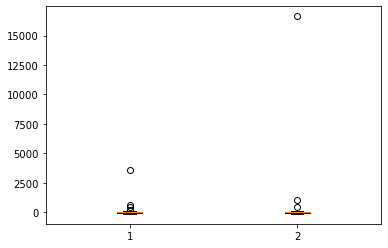

90.18167779981395 403.5939542405117


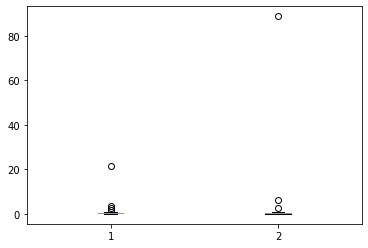

1.0067045183207435 2.613610778240553


In [74]:
gt = pd.read_csv(fr'C:\Users\frodo\OneDrive - FruitSpec\Syngenta\tomato\230123\ground_truth.csv')[['GT-W','plot_id']]
gt = gt[['plot_id','GT-W']]
df_SIZE = pd.read_csv(fr'C:\Users\frodo\OneDrive - FruitSpec\Syngenta\tomato\230123\results_size.csv',dtype={'row':str})
df = df_SIZE.merge(gt,how='left',on = ['plot_id'])
df['error_weight'] = df['avg_weight']-df['GT-W']
df['error'] = abs(df['error_weight']/df['GT-W'])
df['acc'] = 1 - df['error']
df_1 = df[df["row"].isin(['9','11','7','18','21','25'])]
df_2 = df[df["row"].isin(['9','10','8','18','20','26'])]

plt.boxplot([df_1['error_weight'].dropna(),df_2['error_weight'].dropna()],vert=1)
plt.show()
print(df_1['error_weight'].mean(),df_2['error_weight'].mean())

plt.boxplot([df_1['error'].dropna(),df_2['error'].dropna()],vert=1)
plt.show()
print(df_1['error'].mean(),df_2['error'].mean())

df_1.to_csv(r"C:\Users\frodo\OneDrive - FruitSpec\Syngenta\tomato\230123\side_1_size.csv",index=False)
df_2.to_csv(r"C:\Users\frodo\OneDrive - FruitSpec\Syngenta\tomato\230123\side_2_size.csv",index=False)

Debug Color

In [31]:
def apply_trees_color(path,row):
    row_folder = os.path.join(path,row)
    df_res = open_measures(row_folder)
    trees_slices = slice_to_trees(os.path.join(row_folder, [i for i in os.listdir(row_folder) if 'slice_data' in i][0]),None,None)
    for tree_id, df_tree in trees_slices.groupby('tree_id'):
        count, colors_class = trackers_into_value(df_tree,df_res,analysis='color')
        plot_id = map_tree_into_plot(row, tree_id)
        yield plot_id, count, colors_class

In [32]:
def run_color_plots(scan_pre,scan_post):
    df_sum = pd.DataFrame()
    for (pre, post) in zip(os.listdir(scan_pre), os.listdir(scan_post)):
        if post in ['1', '2', '3', '4', '5', '6', '12', '13', '14', '15', '16', '17','10','8','20']:
            continue
        for (pre_plot_id, pre_count, pre_measures), (post_plot_id, post_count, post_measures) in zip(apply_trees_color(scan_pre, pre), apply_trees_color(scan_post, post)):
            hist_all = plt.hist(pre_measures,density=False,bins=[1,2,3,4,5])[0]
            hist_nonPicked = plt.hist(post_measures, density=False,bins=[1,2,3,4,5])[0]
            plt.close()
            hist_picked =  hist_all - hist_nonPicked
            hist_picked = [max(i,0) for i in hist_picked ]
            hist_picked = hist_picked/ np.sum(hist_picked)
            picked_count = pre_count - post_count
            picked_bins = picked_count * hist_picked

            try:
                bin1,bin2,bin3,bin4 = int(picked_bins[0]),int(picked_bins[1]),int(picked_bins[2]),picked_count-(int(picked_bins[0])+int(picked_bins[1])+int(picked_bins[2]))
            except:
                bin1,bin2,bin3,bin4 = 0,0,0,0
            df_sum = df_sum.append({'row': pre,
                                    'plot_id': pre_plot_id,
                                    "bin1":bin1,
                                    "bin2":bin2,
                                    "bin3":bin3,
                                    "bin4":bin4}, ignore_index=True)
    return df_sum

In [41]:
def run_color_com(scan_pre,scan_post):
    df_sum = pd.DataFrame()
    for (row1, row2) in [('3', '15'), ('5', '13'), ('6', '12'), ('1', '17'), ('2', '16')]:
        pre_measures = pd.Series()
        pre_count = 0
        post_measures = pd.Series()
        post_count = 0
        for row in (row1, row2):
            row_folder = os.path.join(scan_pre, row)
            df_res = open_measures(row_folder)
            count, measures = trackers_into_value(None, df_res, analysis='color')
            pre_measures = pd.concat([pre_measures, measures], axis=0)
            pre_count += count

            row_folder = os.path.join(scan_post, row)
            df_res = open_measures(row_folder)
            count, measures = trackers_into_value(None, df_res, analysis='color')
            post_measures = pd.concat([post_measures, measures], axis=0)
            post_count += count

        hist_all = plt.hist(pre_measures,density=False,bins=[1,2,3,4,5])[0]
        plt.show()
        plt.close()
        hist_nonPicked = plt.hist(post_measures, density=False,bins=[1,2,3,4,5])[0]
        plt.show()
        plt.close()
        hist_picked =  hist_all - hist_nonPicked
        hist_picked = [max(i,0) for i in hist_picked ]
        hist_picked = hist_picked/ np.sum(hist_picked)
        picked_count = pre_count - post_count
        picked_bins = picked_count * hist_picked
        try:
                bin1,bin2,bin3,bin4 = int(picked_bins[0]),int(picked_bins[1]),int(picked_bins[2]),picked_count-(int(picked_bins[0])+int(picked_bins[1])+int(picked_bins[2]))
        except:
                bin1,bin2,bin3,bin4 = 0,0,0,0
        df_sum = df_sum.append({'row': (row1,row2),
                                'plot_id': None,
                                "bin1":bin1,
                                "bin2":bin2,
                                "bin3":bin3,
                                "bin4":bin4}, ignore_index=True)
    return df_sum

C:\Users\frodo\AppData\Local\Temp\ipykernel_6404\2953213129.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pre_measures = pd.Series()
C:\Users\frodo\AppData\Local\Temp\ipykernel_6404\2953213129.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  post_measures = pd.Series()


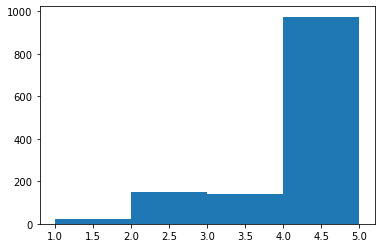

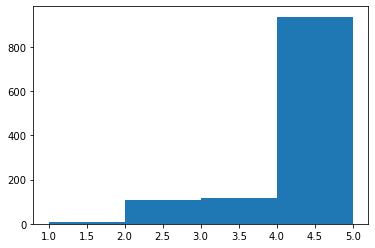

C:\Users\frodo\AppData\Local\Temp\ipykernel_6404\2953213129.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pre_measures = pd.Series()
C:\Users\frodo\AppData\Local\Temp\ipykernel_6404\2953213129.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  post_measures = pd.Series()


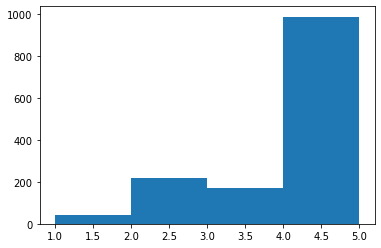

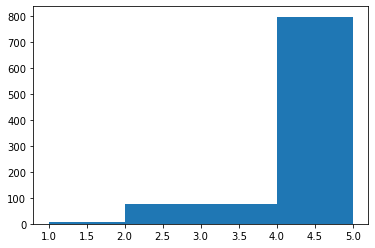

C:\Users\frodo\AppData\Local\Temp\ipykernel_6404\2953213129.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pre_measures = pd.Series()
C:\Users\frodo\AppData\Local\Temp\ipykernel_6404\2953213129.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  post_measures = pd.Series()


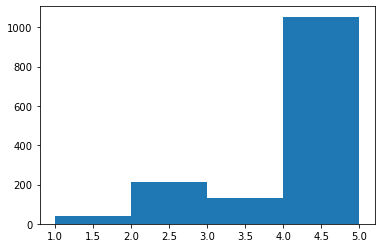

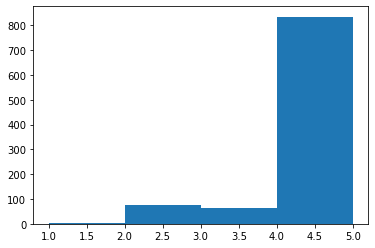

C:\Users\frodo\AppData\Local\Temp\ipykernel_6404\2953213129.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pre_measures = pd.Series()
C:\Users\frodo\AppData\Local\Temp\ipykernel_6404\2953213129.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  post_measures = pd.Series()


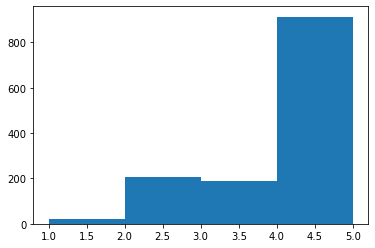

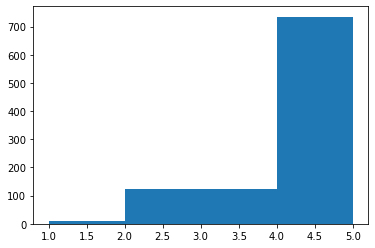

C:\Users\frodo\AppData\Local\Temp\ipykernel_6404\2953213129.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pre_measures = pd.Series()
C:\Users\frodo\AppData\Local\Temp\ipykernel_6404\2953213129.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  post_measures = pd.Series()


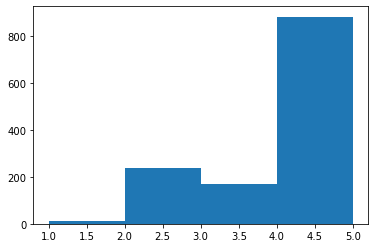

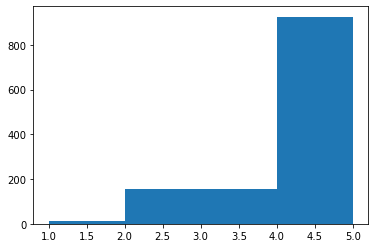

In [42]:
scan_pre = fr'C:\Users\frodo\OneDrive - FruitSpec\Syngenta\tomato\230123\pre'
scan_post = fr'C:\Users\frodo\OneDrive - FruitSpec\Syngenta\tomato\230123\post'
output_path = fr'C:\Users\frodo\OneDrive - FruitSpec\Syngenta\tomato\230123\results_color_com.csv'
# df_COLOR = run_color_plots(scan_pre,scan_post)
# df_COLOR.to_csv(output_path,index=False,mode="w")
df_SIZE = run_color_com(scan_pre,scan_post)
df_SIZE.to_csv(output_path,index=False,mode="w")

In [46]:
df = pd.read_csv(r"C:\Users\frodo\OneDrive - FruitSpec\Syngenta\tomato\230123\fs_harvest_report.csv")
# insert DB - queries txt file
project_id = 8186
txt_file = open(r"C:\Users\frodo\OneDrive - FruitSpec\Syngenta\tomato\230123\updateMySQL.txt","w")
for i,row in df.iterrows():
    q = f"""
        UPDATE project_plot
        SET
            project_plot_scan_date = STR_TO_DATE("23/01/2023","%d/%m/%Y"),
            Predicted_W = {row['weight_avg_gr']},
            WeightSTD = {row['weight_std']},
            YE = {row['count']}
        WHERE
            plot_id = {row['plot_id']} AND project_ID = {project_id};"""
    txt_file.writelines(q)
    # txt_file.write('\n')

txt_file.close()